In [1]:
import os

import numpy as np
import pandas as pd

import IPython.display as ipd

import torchaudio
import datasets as hfd

import librosa
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.1, palette='pastel')

In [2]:
import logging
logging_format_str = '%(asctime)s:%(name)s:%(levelname)s:%(message)s'
logging.basicConfig(format=logging_format_str, level=logging.WARNING)
logger = logging.getLogger('STT')
logger.setLevel(level=logging.DEBUG)

In [3]:
DATA_ROOT_DP = os.environ['DATA_HOME']
CV_DP = f'{DATA_ROOT_DP}/datasets/cv-corpus-8.0-2022-01-19/be'
CLIPS_DP = os.path.join(CV_DP, 'clips')

## load tables

In [4]:
df_train = pd.read_csv(os.path.join(CV_DP, 'train.tsv'), delimiter='\t')
df_dev = pd.read_csv(os.path.join(CV_DP, 'dev.tsv'), delimiter='\t')

assert df_train['path'].duplicated().sum() == 0
assert df_dev['path'].duplicated().sum() == 0

logger.debug(f'df_train.shape: {df_train.shape}')
logger.debug(f'df_dev.shape: {df_dev.shape}')

print(f'clips in train set: {df_train["path"].nunique()}')
print(f'clips in dev set: {df_dev["path"].nunique()}')

2022-04-18 18:19:58,760:STT:DEBUG:df_train.shape: (314305, 10)
2022-04-18 18:19:58,761:STT:DEBUG:df_dev.shape: (15803, 10)


clips in train set: 314305
clips in dev set: 15803


In [5]:
df_train.head(2)

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,locale,segment
0,9356b041bf9c40eb40bc036a354b69f47709e0cae8d619...,common_voice_be_29365148.mp3,Прыкладам таму можа быць мой уласны досвед.,2,0,NaN,NaN,NaN,be,NaN
1,9356b041bf9c40eb40bc036a354b69f47709e0cae8d619...,common_voice_be_29365149.mp3,"У яго было столькі пазітыву і таланту, што хап...",2,1,NaN,NaN,NaN,be,NaN


In [6]:
def two_sets_stats(s1, s2):
    print(f'initial lens. iterable 1: {len(s1)}. iterable 2: {len(s2)}')
    s1 = set(s1)
    s2 = set(s2)
    print(f's1: {len(s1)}\ns2: {len(s2)}')
    print(f's1 & s2: {len(s1 & s2)}')
    print(f'sym dif: {len(s1.symmetric_difference(s2))}')
    print(f's1 - s2: {len(s1 - s2)}')
    print(f's2 - s1: {len(s2 - s1)}')

In [7]:
two_sets_stats(df_train['client_id'], df_dev['client_id'])

initial lens. iterable 1: 314305. iterable 2: 15803
s1: 2222
s2: 1017
s1 & s2: 0
sym dif: 3239
s1 - s2: 2222
s2 - s1: 1017


## Dev set audio statistics:
* dev is statistically significant relative to train

In [8]:
def describe_audio(audio_fp):
    audio, sr = librosa.load(audio_fp, mono=False, sr=None)
    n_channels = 1 if len(audio.shape) == 1 else audio.shape[0]
    n_samples = audio.shape[-1]
    ext = os.path.splitext(audio_fp)[-1]
    
    audio_abs = np.abs(audio)
    max_value = np.max(audio)
    max_abs_value = np.max(audio_abs)
    perc95_abs_value = np.quantile(audio_abs, 0.95)
    
    res = dict(
        filename=os.path.basename(audio_fp),
        n_channels=n_channels, 
        n_samples=n_samples, 
        sampling_rate=sr,
        ext=ext,
        max_value=max_value,
        max_abs_value=max_abs_value,
        perc95_abs_value=perc95_abs_value,
    )
    return res

In [9]:
clips_all_fns = os.listdir(CLIPS_DP)
print(f'total # of clips: {len(clips_all_fns)}')

total # of clips: 740710


In [10]:
clips_dev_fps = [os.path.join(CLIPS_DP, fn) for fn in df_dev['path']]
print(len(clips_dev_fps))

15803


In [11]:
import warnings
warnings.filterwarnings("ignore", message="PySoundFile failed")

In [12]:
# stats = []
# for fp in tqdm(clips_dev_fps):
#     try:
#         cur_stats = describe_audio(fp)
#         stats.append(cur_stats)
#     except Exception as e:
#         e_message = {'exception': f'{type(e).__name__}: {e}'}
#         stats.append(e_message)

  0%|          | 0/15803 [00:00<?, ?it/s]

In [14]:
# stats_df = pd.DataFrame(stats)
# print(stats_df.shape)
# stats_df.head()

(15803, 8)


,filename,n_channels,n_samples,sampling_rate,ext,max_value,max_abs_value,perc95_abs_value
0,common_voice_be_26930039.mp3,1,274176,32000,.mp3,0.106049,0.132660,0.040985
1,common_voice_be_26930040.mp3,1,294912,32000,.mp3,0.120270,0.120270,0.044250
2,common_voice_be_26930047.mp3,1,199296,32000,.mp3,0.110748,0.133881,0.048462
3,common_voice_be_26930086.mp3,1,176256,32000,.mp3,0.098938,0.116486,0.044403
4,common_voice_be_26930087.mp3,1,179712,32000,.mp3,0.186890,0.186890,0.062775


In [18]:
# os.makedirs('eda_data', exist_ok=True)

In [19]:
# stats_df.to_csv('eda_data/dev_clips_stats.csv', index=False)

### read Dev set audio stats

In [14]:
stats_df = pd.read_csv('eda_data/dev_clips_stats.csv')
print(stats_df.shape)

(15803, 8)


In [16]:
stats_df.head()

,filename,n_channels,n_samples,sampling_rate,ext,max_value,max_abs_value,perc95_abs_value
0,common_voice_be_26930039.mp3,1,274176,32000,.mp3,0.106049,0.132660,0.040985
1,common_voice_be_26930040.mp3,1,294912,32000,.mp3,0.120270,0.120270,0.044250
2,common_voice_be_26930047.mp3,1,199296,32000,.mp3,0.110748,0.133881,0.048462
3,common_voice_be_26930086.mp3,1,176256,32000,.mp3,0.098938,0.116486,0.044403
4,common_voice_be_26930087.mp3,1,179712,32000,.mp3,0.186890,0.186890,0.062775


In [17]:
stats_df[['n_channels', 'sampling_rate', 'ext']].drop_duplicates()

,n_channels,sampling_rate,ext
0,1,32000,.mp3


In [36]:
sns.set(palette='muted');

In [56]:
float_cols = ['max_value', 'max_abs_value', 'perc95_abs_value']

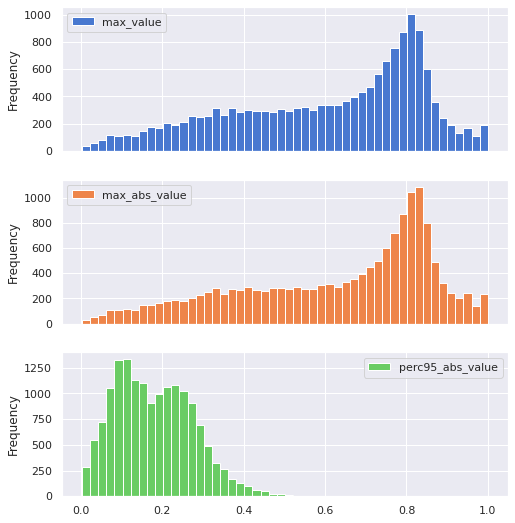

In [44]:
stats_df[float_cols].plot(
    kind='hist', subplots=True, figsize=(8, 9), bins=50);

### join speaker and sentence columns

In [18]:
stats_df2 = stats_df.merge(
    df_dev[['client_id', 'path', 'sentence']].rename(columns={'path': 'filename'}), 
    on='filename', how='left'
)
assert stats_df.shape[0] == stats_df2.shape[0]
stats_df2.head(1)

,filename,n_channels,n_samples,sampling_rate,ext,max_value,max_abs_value,perc95_abs_value,client_id,sentence
0,common_voice_be_26930039.mp3,1,274176,32000,.mp3,0.106049,0.13266,0.040985,41fd86ef04ed09d30e0b82d494afa3b7c37542bcae42dd...,"Будынак ратушы быў драўляны, прамавугольны ў п..."


### compute speech rate

In [19]:
import re

In [20]:
non_word_chars_re = re.compile(r"[^\w']+")

In [21]:
def count_chars(text: str):
    filtered = non_word_chars_re.sub('', text)
    n_chars = len(filtered)
    return n_chars

In [22]:
stats_df2.head(1)

,filename,n_channels,n_samples,sampling_rate,ext,max_value,max_abs_value,perc95_abs_value,client_id,sentence
0,common_voice_be_26930039.mp3,1,274176,32000,.mp3,0.106049,0.13266,0.040985,41fd86ef04ed09d30e0b82d494afa3b7c37542bcae42dd...,"Будынак ратушы быў драўляны, прамавугольны ў п..."


In [23]:
stats_df2['n_chars'] = stats_df2['sentence'].apply(count_chars)

In [24]:
stats_df2['samples_per_char'] = stats_df2['n_samples'] / stats_df2['n_chars']

In [25]:
stats_df2['samples_per_char'].describe()

count    15803.000000
mean      4285.017112
std       1251.781475
min       1738.105263
25%       3430.256180
50%       3995.234043
75%       4824.972973
max      17811.692308
Name: samples_per_char, dtype: float64

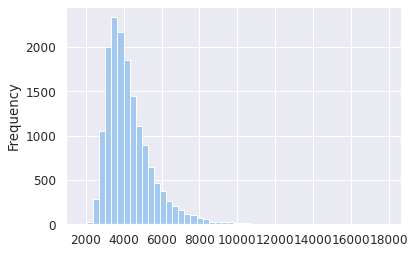

In [26]:
stats_df2['samples_per_char'].plot.hist(bins=50);

## describe speakers in Dev set

In [27]:
cols_to_mean = ['max_value', 'max_abs_value', 'perc95_abs_value', 'samples_per_char']

In [28]:
speaker_stats_dev = stats_df2.groupby('client_id')[cols_to_mean].agg('mean')
speaker_stats_dev.columns = speaker_stats_dev.columns + '_mean'

In [29]:
speaker_stats_dev.head()

,max_value_mean,max_abs_value_mean,perc95_abs_value_mean,samples_per_char_mean
client_id,,,,
0009accf1b05e9700f67ba6f701f2374b049ae405de33a4d6414c07c26e8823f8a672c98875c6dbfa815bfa263e6afbfc3816e2aff9fe29609ecf571d1be1e92,0.509954,0.509954,0.097533,3858.956000
006db7ca99848816296461b074c5fd0a239b11d4ad62f11319d3fa985e5b6d0b5601d6abd97f35f78291faffd7c5fa1bdf2d5a16b11509445db139aefa85f783,0.795581,0.799792,0.224384,4123.368708
0076d72b93a07cfe19b8ab8f8b8f25459fde5fdabb4ebc63c2965b9597351b2690f938345a17027bb198d5428d4f462b0e363cbb020eaf70b0ad0899fff18e2f,0.455738,0.477624,0.081367,4787.720160
00a25dee6aae129d2c1292e287e65a6888fd7c00f4d442d97d2ddd6e804606f103f181edb0f50a5e20b70f6b8512dfe21fe655786bb20128996dd9a1d323276a,0.592803,0.626172,0.098435,4889.503917
00b7fb46456ec9b7d75daaa7a8f839438173857f6805d23b1242667aa818cacf80acdeb35c0bb3c71d0f003b6ff1e83efb538d458d743c3f59bde6f0fc94839e,0.830652,0.830652,0.327669,4626.052099


In [30]:
sns.set(font_scale=1, palette='muted');

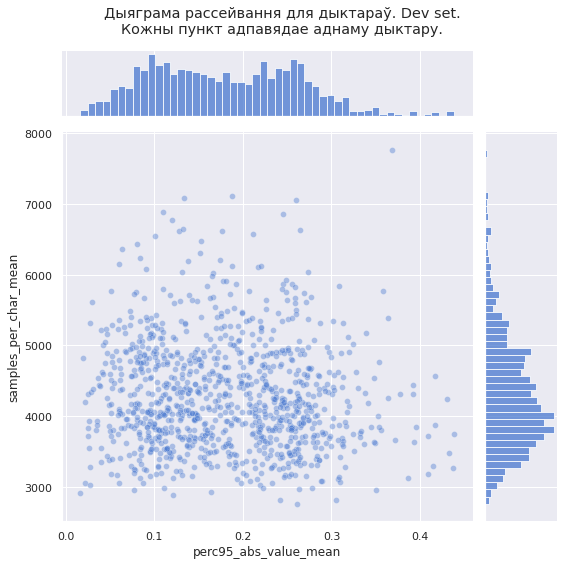

In [33]:
grid = sns.jointplot(
    data=speaker_stats_dev, 
    x='perc95_abs_value_mean', y='samples_per_char_mean', 
    alpha=0.4,
    marginal_kws=dict(bins=50), height=8, 
);

grid.fig.suptitle('Дыяграма рассейвання для дыктараў. Dev set.\n'
                  'Кожны пункт адпавядае аднаму дыктару.');
grid.fig.tight_layout();

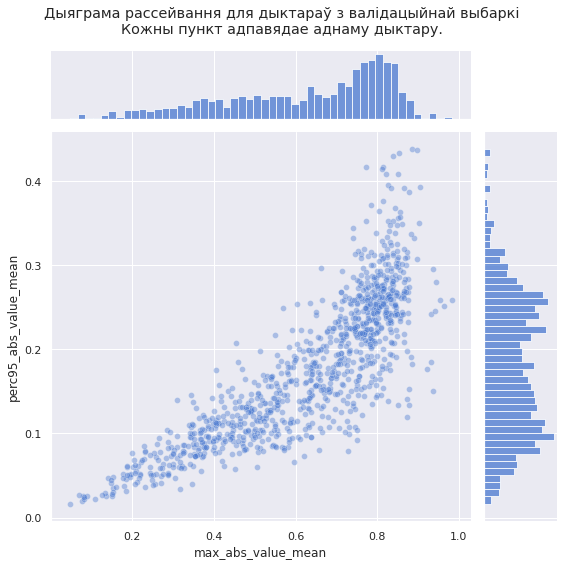

In [187]:
grid = sns.jointplot(
    data=speaker_stats_dev, 
    x='max_abs_value_mean', y='perc95_abs_value_mean', 
    alpha=0.4,
    marginal_kws=dict(bins=50), height=8, 
);

grid.fig.suptitle('Дыяграма рассейвання для дыктараў з валідацыйнай выбаркі\n'
                  'Кожны пункт адпавядае аднаму дыктару.');
grid.fig.tight_layout();

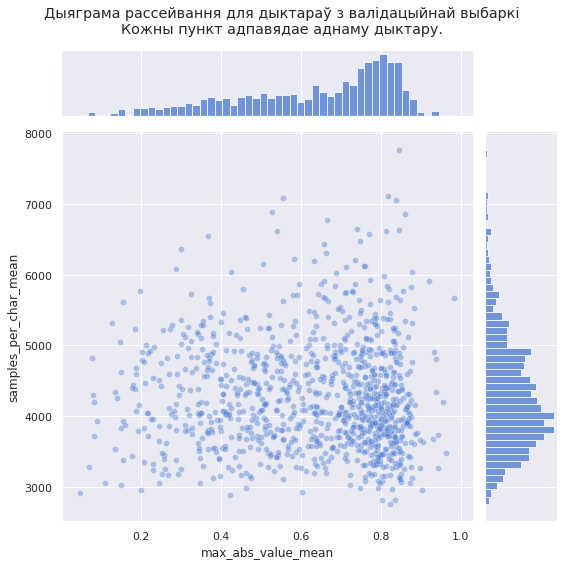

In [189]:
grid = sns.jointplot(
    data=speaker_stats_dev, 
    x='max_abs_value_mean', y='samples_per_char_mean', 
    alpha=0.4,
    marginal_kws=dict(bins=50), height=8, 
);

grid.fig.suptitle('Дыяграма рассейвання для дыктараў з валідацыйнай выбаркі\n'
                  'Кожны пункт адпавядае аднаму дыктару.');
grid.fig.tight_layout();

## Train set voicing stats

In [34]:
speakers_vc = df_train['client_id'].value_counts().sort_values(ascending=False)
speakers_vc = speakers_vc.rename('n_clips').to_frame().rename_axis(index='client_id').reset_index()
print(speakers_vc.shape)

(2222, 2)


In [35]:
speakers_vc.head()

,client_id,n_clips
0,4142df127af0c93b372ac7ef241884960419789dfb74de...,2625
1,b158ad3bdcb4835dff8e5bac99225aeddc3b274d6d9d47...,2315
2,231f08739b225a6c9420e9dbc1f24cf6695b8710c20cfb...,2267
3,db3c760a1719b8f2ee056a12e4fb65b4578d7b454bf4c0...,2193
4,235555b6d6c6b4d882a5a0e6160f245c03e61d266c112d...,1991


In [36]:
speakers_vc['n_clips'].describe()

count    2222.000000
mean      141.451395
std       248.258718
min        13.000000
25%        34.000000
50%        59.000000
75%       122.750000
max      2625.000000
Name: n_clips, dtype: float64

### histograms

In [37]:
import math

In [38]:
sns.set(palette='muted');

q95: 580.900000


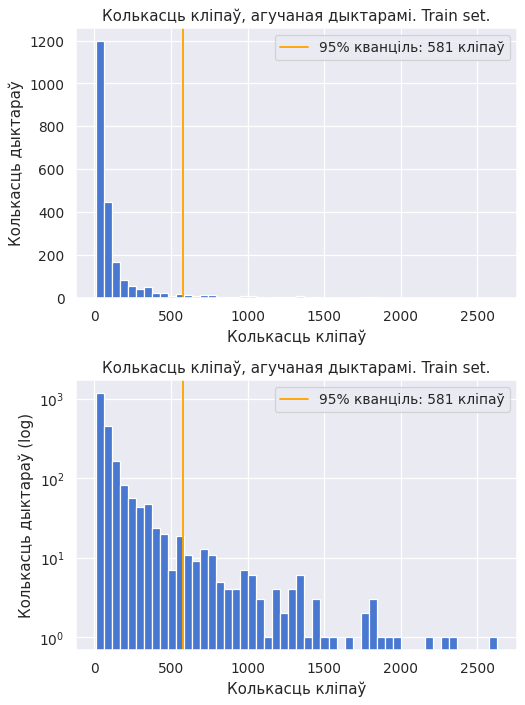

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), dpi=90)

h = ax[0].hist(speakers_vc['n_clips'], bins=50);
ax[1].hist(speakers_vc['n_clips'], bins=50, log=True);

q95 = speakers_vc['n_clips'].quantile(0.95)
print(f'q95: {q95 :2f}')

ax[0].set_ylabel('Колькасць дыктараў');
ax[1].set_ylabel('Колькасць дыктараў (log)');
for _ax in ax:
    _ax.set_xlabel('Колькасць кліпаў');
    _ax.axvline(q95, label=f'95% кванціль: {math.ceil(q95)} кліпаў', color='orange');
    _ax.legend();
    _ax.set_title('Колькасць кліпаў, агучаная дыктарамі. Train set.');

fig.tight_layout();

### pie chart

In [43]:
q = speakers_vc['n_clips'].quantile([0, 0.5, 0.85, 0.95, 1])
q

0.00      13.00
0.50      59.00
0.85     216.85
0.95     580.90
1.00    2625.00
Name: n_clips, dtype: float64

In [48]:
sns.set(palette='pastel');

In [45]:
pie_stats = q.apply(np.ceil).astype('int')
pie_stats = pie_stats.rename('n_clips_hi').to_frame().rename_axis(index='perc').reset_index()
pie_stats['perc'] = (pie_stats['perc'] * 100).astype('int')
pie_stats['perc_bucket'] = pie_stats['perc'] - pie_stats['perc'].shift(1)
pie_stats['n_clips_lo'] = pie_stats['n_clips_hi'].shift(1)
pie_stats = pie_stats.iloc[1:].copy()
pie_stats['n_clips_lo'] = pie_stats['n_clips_lo'].astype('int')
pie_stats['perc_bucket'] = pie_stats['perc_bucket'].astype('int')
pie_stats['n_clips_bucket'] = pie_stats.apply(lambda row: f'[{row["n_clips_lo"]}-{row["n_clips_hi"]}) кліпаў', axis=1)
pie_stats

,perc,n_clips_hi,perc_bucket,n_clips_lo,n_clips_bucket
1,50,59,50,13,[13-59) кліпаў
2,85,217,35,59,[59-217) кліпаў
3,95,581,10,217,[217-581) кліпаў
4,100,2625,5,581,[581-2625) кліпаў


In [46]:
sns.set(palette='pastel');

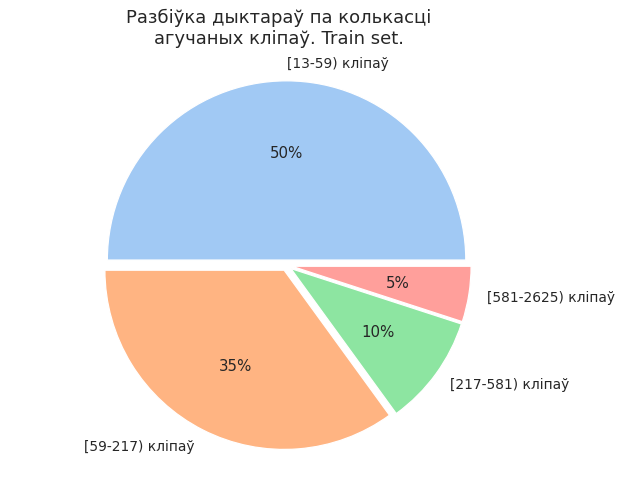

In [47]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=90)
ax.pie(
    pie_stats['perc_bucket'], 
    labels=pie_stats['n_clips_bucket'], 
    startangle=0, 
    explode=np.repeat(0.03, len(pie_stats)),
    autopct='%1.f%%',
    shadow=False
);
ax.axis('equal');
fig.suptitle('Разбіўка дыктараў па колькасці\nагучаных кліпаў. Train set.');

## Dev set voicing stats

In [49]:
speakers_vc_dev = df_dev['client_id'].value_counts().sort_values(ascending=False)
speakers_vc_dev = speakers_vc_dev.rename('n_clips').to_frame().rename_axis(index='client_id').reset_index()
print(speakers_vc_dev.shape)

(1017, 2)


In [50]:
speakers_vc_dev.head()

,client_id,n_clips
0,0646436d8a6a0d9bbd5fd0a8737bf4c4d88e6eb66ebcae...,23
1,580dfef13676b6cfeab8544811612bbfe06a328ac3467f...,23
2,59ee3388f08592e5d58431e745311793a601c7750a6697...,23
3,5b8ff21270ee3797f05d5d7daaf4a0151c73232e8eed36...,23
4,849e4c9552eade24cb2b3b826b399799988d55816f1f5e...,23


In [51]:
speakers_vc_dev['n_clips'].describe()

count    1017.000000
mean       15.538840
std         2.938128
min         6.000000
25%        13.000000
50%        15.000000
75%        18.000000
max        23.000000
Name: n_clips, dtype: float64

### pie chart

In [52]:
q = speakers_vc_dev['n_clips'].quantile([0, 0.5, 0.85, 0.95, 1])
q

0.00     6.0
0.50    15.0
0.85    19.0
0.95    20.0
1.00    23.0
Name: n_clips, dtype: float64

In [53]:
pie_stats = q.apply(np.ceil).astype('int')
pie_stats = pie_stats.rename('n_clips_hi').to_frame().rename_axis(index='perc').reset_index()
pie_stats['perc'] = (pie_stats['perc'] * 100).astype('int')
pie_stats['perc_bucket'] = pie_stats['perc'] - pie_stats['perc'].shift(1)
pie_stats['n_clips_lo'] = pie_stats['n_clips_hi'].shift(1)
pie_stats = pie_stats.iloc[1:].copy()
pie_stats['n_clips_lo'] = pie_stats['n_clips_lo'].astype('int')
pie_stats['perc_bucket'] = pie_stats['perc_bucket'].astype('int')
pie_stats['n_clips_bucket'] = pie_stats.apply(lambda row: f'[{row["n_clips_lo"]}-{row["n_clips_hi"]}) кліпаў', axis=1)
pie_stats

,perc,n_clips_hi,perc_bucket,n_clips_lo,n_clips_bucket
1,50,15,50,6,[6-15) кліпаў
2,85,19,35,15,[15-19) кліпаў
3,95,20,10,19,[19-20) кліпаў
4,100,23,5,20,[20-23) кліпаў


In [54]:
sns.set(palette='pastel');

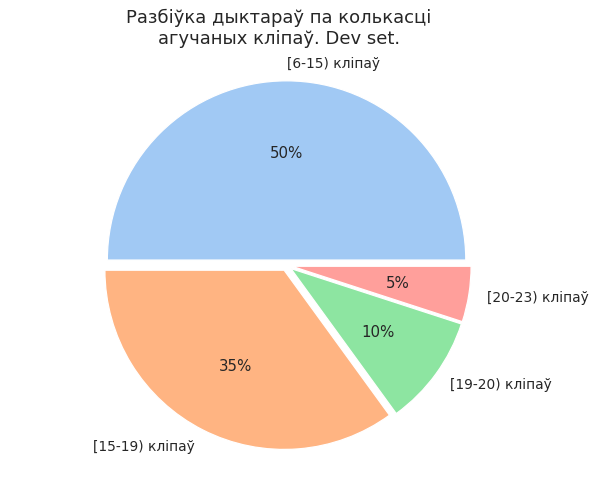

In [55]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=90)
ax.pie(
    pie_stats['perc_bucket'], 
    labels=pie_stats['n_clips_bucket'], 
    startangle=0, 
    explode=np.repeat(0.03, len(pie_stats)),
    autopct='%1.f%%',
    shadow=False
);
ax.axis('equal');
fig.suptitle('Разбіўка дыктараў па колькасці\nагучаных кліпаў. Dev set.');

## Debug

### datasets.Audio vs torchaudio.load

In [118]:
ix = 853
print(os.path.relpath(ds[ix]['audio']['path'], CV_DP))

x1 = ds[ix]['audio']

x2 = torchaudio.load(ds[ix]['audio']['path'])

x2r = list(x2)
x2r[0] = resampler(x2[0])
x2r[1] = 16_000

print(x2[0].max().item() == x2r[0].max().item())
print(x1['array'].max() == x2r[0].max().item())
print(x1['array'].max(), x2[0].max().item(), x2r[0].max().item())

clips/common_voice_be_29071231.mp3
False
True
0.42713568 0.43676280975341797 0.4271356761455536


In [119]:
ipd.Audio(data=x1['array'], rate=x1['sampling_rate'], autoplay=True)

In [120]:
ipd.Audio(data=x2r[0], rate=x2r[1], autoplay=True)

In [121]:
ipd.Audio(data=x2[0], rate=x2[1], autoplay=True)